In [41]:
#!pip install install dowhy
#!pip install RISE
#!pip install pgmpy

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.inference import VariableElimination
import graphviz
import pandas

from dowhy import gcm, CausalModel
import dowhy.datasets
from IPython.display import Image, display
import warnings
warnings.filterwarnings('ignore')

# Goal

When we explain a complex concept in white board, we draw some circles and arrows joining them. That in effect is a DAG (direct acyclic graph) loosely speaking - assuming there are no closed cycles. That is quintessence way to express domain knowledge.
We can take a DAG and:
1. store it as a __Knowledge Graph__ in a Graph DB with some kind of data so that this can answer some questions about the system.
2. convert it to a __Bayesian Network__ by adding the Conditional Probability Distribution (CPD) to it so that this can answer some other questions about the system.
3. convert it to a __Causal model__ (Bayesian Network with a little more rigor if needed) with some structural equation so that this can answer some other questions about the system.

Each of the above takes domain knowledge and helps answer some questions about it.

__In this notebook, we will take a DAG, and drive it through the evolution of KG -> Bayesian Network -> Causal Model to make clear the options we have in mining domain knowledge.__


## Knowledge Graph
follows

## Bayesian Network

_These examples are all taken from the excellent course https://www.coursera.org/specializations/probabilistic-graphical-models . To be more precise, these were from an earlier version of the course - for which there is no link anymore - way back in 2012/13s. The course may have looked slightly different then. But these excellent examples are owed to Prof Koller._

#### This example shows how we define:
- a DAG
- and the Conditional Probability Distribution (CPD)
- and for sake of easy visualization show the DAG as a graphviz.Digraph()
#### Note:
- Then we instrospect the model

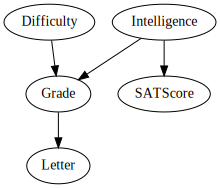

In [43]:
# A Bayesian Net visual represntation
studentnetwork=graphviz.Digraph()
studentnetwork.edge('Difficulty', 'Grade')
studentnetwork.edge('Intelligence', 'Grade')
studentnetwork.edge('Intelligence','SATScore')
studentnetwork.edge('Grade', 'Letter')
studentnetwork

### Explain the DAG
- difficulty implies how hard is the course that the student takes
- intelligence implies student's intelligence
- grade is the grade in the course work
- letter is the strenght of the recommendation letter given to the student by the Prof
- SAT score obtained by the student.

For simplicity, all variables are binary valued except for Grade which has 3 values.

This is a simple student network. This is the not the only model that may exist. There could be many other models. For example, there could be an arrow from Intelligence to Difficulty because more intelligent students take more harder courses etc. But let us assume that experts have got together and said that for the problem we are trying to solve, this is good enough approximation.

We will next define a Bayesian Network with this. So for now, we will assume we know the CPD. Later on, we will have another example of Bayesian Network where we will give the raw data - and the network will be `fitted` to that data to generate the CPD.

In [44]:
# Create a networkx graph object to show the Bayesian Net structure
bbn = nx.DiGraph([('Difficulty', 'Grade'),
                           ('Intelligence', 'Grade'),
                           ('Intelligence','SATScore'),
                           ('Grade', 'Letter')])

# We could easily defined this directly in BayesianNetwork([('Difficulty', 'Grade'),
#                           ('Intelligence', 'Grade'),
#                           ('Intelligence','SATScore'),
#                           ('Grade', 'Letter')])
# can give the networkx digraph as input directly
student_model = BayesianNetwork(ebunch=bbn)
cpd_table = TabularCPD('grade', 2,
                       [[0.7, 0.6, 0.6, 0.2],[0.3, 0.4, 0.4, 0.8]],
                       ['intel', 'diff'], [2, 2])

cpd_difficulty = TabularCPD(
    variable="Difficulty", variable_card=2, values=[[0.6], [0.4]]
)
cpd_intelligence = TabularCPD(
    variable="Intelligence", variable_card=2, values=[[0.7], [0.3]]
)
cpd_grade = TabularCPD(
    variable="Grade",
    variable_card=3,
    values=[[0.3, 0.05, 0.9,0.5], [0.4, 0.25, 0.08, 0.3],[0.3, 0.7, 0.02, 0.2]],
    evidence=["Intelligence","Difficulty"],
    evidence_card=[2, 2],
)

cpd_satscore = TabularCPD(
    variable="SATScore",
    variable_card=2,
    values=[[0.95, 0.2], [0.05, 0.8]],
    evidence=["Intelligence"],
    evidence_card=[2],
)

cpd_letter = TabularCPD(
    variable="Letter",
    variable_card=2,
    values=[[0.1, 0.4, 0.99], [0.9, 0.6, 0.01]],
    evidence=["Grade"],
    evidence_card=[3],
)

# Associating the parameters with the model structure
student_model.add_cpds(
    cpd_difficulty, cpd_intelligence, cpd_grade, cpd_satscore, cpd_letter
)

In [45]:
for cpdList in student_model.get_cpds():
        print(cpdList.variable)
        print(cpdList.variables)
        print(cpdList)
        print('\n\n')

Difficulty
['Difficulty']
+---------------+-----+
| Difficulty(0) | 0.6 |
+---------------+-----+
| Difficulty(1) | 0.4 |
+---------------+-----+



Intelligence
['Intelligence']
+-----------------+-----+
| Intelligence(0) | 0.7 |
+-----------------+-----+
| Intelligence(1) | 0.3 |
+-----------------+-----+



Grade
['Grade', 'Intelligence', 'Difficulty']
+--------------+-----------------+-----------------+-----------------+-----------------+
| Intelligence | Intelligence(0) | Intelligence(0) | Intelligence(1) | Intelligence(1) |
+--------------+-----------------+-----------------+-----------------+-----------------+
| Difficulty   | Difficulty(0)   | Difficulty(1)   | Difficulty(0)   | Difficulty(1)   |
+--------------+-----------------+-----------------+-----------------+-----------------+
| Grade(0)     | 0.3             | 0.05            | 0.9             | 0.5             |
+--------------+-----------------+-----------------+-----------------+-----------------+
| Grade(1)     | 0.

### Instrospect the model
- Checking if the cpds are valid for the model
- Viewing nodes of the model
- Viewing edges of the model
- Checking independcies of a node
- Listing all Independencies


In [46]:
# Checking if the cpds are valid for the model
student_model.check_model()

True

In [47]:
# Viewing edges of the model
student_model.edges()

OutEdgeView([('Difficulty', 'Grade'), ('Grade', 'Letter'), ('Intelligence', 'Grade'), ('Intelligence', 'SATScore')])

In [48]:
# Checking independcies of a node
student_model.local_independencies("Grade")

(Grade ⟂ SATScore | Difficulty, Intelligence)

In [49]:
# Listing all Independencies
student_model.get_independencies()

(Grade ⟂ SATScore | Intelligence)
(Grade ⟂ SATScore | Letter, Intelligence)
(Grade ⟂ SATScore | Difficulty, Intelligence)
(Grade ⟂ SATScore | Letter, Difficulty, Intelligence)
(Difficulty ⟂ SATScore, Intelligence)
(Difficulty ⟂ Letter | Grade)
(Difficulty ⟂ Intelligence | SATScore)
(Difficulty ⟂ SATScore | Intelligence)
(Difficulty ⟂ SATScore | Letter, Intelligence)
(Difficulty ⟂ Letter | Grade, SATScore)
(Difficulty ⟂ Letter, SATScore | Grade, Intelligence)
(Difficulty ⟂ SATScore | Letter, Grade, Intelligence)
(Difficulty ⟂ Letter | Grade, SATScore, Intelligence)
(Intelligence ⟂ Difficulty)
(Intelligence ⟂ Letter | Grade)
(Intelligence ⟂ Difficulty | SATScore)
(Intelligence ⟂ Letter | Grade, Difficulty)
(Intelligence ⟂ Letter | Grade, SATScore)
(Intelligence ⟂ Letter | Grade, Difficulty, SATScore)
(Letter ⟂ Difficulty, SATScore, Intelligence | Grade)
(Letter ⟂ SATScore | Intelligence)
(Letter ⟂ SATScore, Intelligence | Grade, Difficulty)
(Letter ⟂ Difficulty, Intelligence | Grade, SAT

#### What is the probability of 'Difficulty': 0, 'Intelligence':1 , 'Grade':2,'SATScore':1, 'Letter': 1

In [50]:
student_model.get_state_probability({'Difficulty': 0, 'Intelligence':1 , 'Grade':2,'SATScore':1, 'Letter': 1})

2.8800000000000002e-05

#### Cross check the answer manually from the CPDs

In [51]:
0.6 * 0.3 * 0.02 * 0.01 * 0.8

2.8800000000000002e-05

In [52]:
student_model.get_state_probability({'Difficulty': 0})

0.6000000000000001

In [53]:
student_model.get_state_probability({'Intelligence':1 })

0.30000000000000004

### Different kinds of Reasoning with the model

#### Calculate the Marginal Probability - of Letter:1

In [54]:
student_model.get_state_probability({'Letter':1})

0.5023360000000001

### Different types of reasoning

1. Causal Reasoning
- These flow down from cause to effect.
- P(Letter|Intelligence=0)
- P(Letter|Intelligence=0, Difficulty=0)

1. Evidential Reasoning
- These flow up from effect to what it can tell about the causes
- P(Difficulty|Grade=2)
- P(Intelligence|Grade=2)


1. Inter Causal Reasoning
- There is no arrow between Difficulty and Intelligence, the 2 causes for Grade. However, observing Grade and Difficulty will we know anything more about the `other cause` ie. Intelligence
- P(Intelligence|Grade=2, Difficulty=1)

All of the above gives an intiution of how knowing one variable informs about the probability of another. Note that there is no clash here with the CPD tables defined. This `knowing one variable informs about the probability of another` is called flow of information of active trail. Let us see how __`Active Trail`__ works. This is an important concept used heavily in Causal Models!


#### Calculate the Conditional Probability - of P(Letter|Intelligence=0)

In [55]:
#from pgmpy.inference import VariableElimination

# it is NOT
#student_model.get_state_probability({'Letter':1,'Intelligence':0})

print('P(Letter|Intelligence=0)')
infer = VariableElimination(student_model)
posterior_p = infer.query(['Letter'], evidence={'Intelligence': 0})
#posterior_p = infer.query(['Letter'])
print(posterior_p)

P(Letter|Intelligence=0)
+-----------+---------------+
| Letter    |   phi(Letter) |
+===========+===============+
| Letter(0) |        0.6114 |
+-----------+---------------+
| Letter(1) |        0.3886 |
+-----------+---------------+


#### Calculate the Conditional Probability - of P(Letter|Intelligence=0, Difficulty=0)

In [56]:
print('P(Letter|Intelligence=0, Difficulty:0)')
infer = VariableElimination(student_model)
posterior_p = infer.query(['Letter'], evidence={'Intelligence': 0, 'Difficulty':0})
print(posterior_p)


P(Letter|Intelligence=0, Difficulty:0)
+-----------+---------------+
| Letter    |   phi(Letter) |
+===========+===============+
| Letter(0) |        0.4870 |
+-----------+---------------+
| Letter(1) |        0.5130 |
+-----------+---------------+


#### Calculate the Conditional Probability - of P(Difficulty|Grade=2)

In [57]:
print('P(Difficulty|Grade=2)')
infer = VariableElimination(student_model)
posterior_p = infer.query(['Difficulty'], evidence={'Grade': 2})
print(posterior_p)


P(Difficulty|Grade=2)
+---------------+-------------------+
| Difficulty    |   phi(Difficulty) |
+===============+===================+
| Difficulty(0) |            0.3707 |
+---------------+-------------------+
| Difficulty(1) |            0.6293 |
+---------------+-------------------+


#### Calculate the Conditional Probability - of P(Intelligence|Grade=2)

In [58]:
print('P(Intelligence|Grade=2)')
infer = VariableElimination(student_model)
posterior_p = infer.query(['Intelligence'], evidence={'Grade': 2})
print(posterior_p)


P(Intelligence|Grade=2)
+-----------------+---------------------+
| Intelligence    |   phi(Intelligence) |
+=================+=====================+
| Intelligence(0) |              0.9211 |
+-----------------+---------------------+
| Intelligence(1) |              0.0789 |
+-----------------+---------------------+


#### A little more complex Intercausal Reasoning
- We are trying to infer about intelligence given data about difficulty and grade
- Technically:
  - In a V-Structure (or collider), observing the collider variable (grade)
  - and observing one cause (difficulty)
  - we are inferring about another cause - intelligence

P(Intelligence|Grade=2, Difficulty=1)

In [59]:
print('P(Intelligence|Grade=2,Difficulty=1)')
infer = VariableElimination(student_model)
posterior_p = infer.query(['Intelligence'], evidence={'Grade': 2, 'Difficulty': 1})
print(posterior_p)

P(Intelligence|Grade=2,Difficulty=1)
+-----------------+---------------------+
| Intelligence    |   phi(Intelligence) |
+=================+=====================+
| Intelligence(0) |              0.8909 |
+-----------------+---------------------+
| Intelligence(1) |              0.1091 |
+-----------------+---------------------+



### Active Trail

When information flows, it is an active trail. When information flow is blocked, there must be a V-Structure (with out evidence) or Inverse V-structure with evidence. Let us see the details.
1. An example - Once we know the SAT scores, we can know infer about the intelligence of the students and the grade. `But if the grade is not known`, then we are stuck at the V-structure. However, if grade is observed, then we can also infer about the course difficulty.
2. Another example - knowing grade of the student may help us may allow us to infer about the intelligence and the difficulty of the course. This is an example of V-Structure becoming an active trail because the Z variable is observable now.
3. Another example - knowing the grade and difficulty of the course, we can infer about the intelligence of the student. Again, this is possible because V-Structure becomes active because Z variable is observable now. This particular inter causal phenomenon is also called explaining away. Once we know the grade and course difficulty, it is easy to infer about the students intelligence - kind of obvious.

#### Formal definition of Active Trail
So formally what is active trail.


#### Fork or Common cause

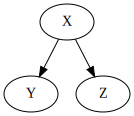

In [60]:

fork=graphviz.Digraph()
fork.edge('X','Y')
fork.edge('X','Z')
fork

#### V-Structure or Common Effect or Collider

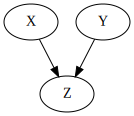

In [61]:
vstructure=graphviz.Digraph()
vstructure.edge('X','Z')
vstructure.edge('Y','Z')
vstructure

#### Confounder or Common Cause for 2 variables which also may be causally linked

- See the difference with the common cause

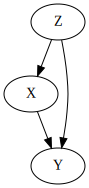

In [62]:
confounder=graphviz.Digraph()
confounder.edge('X','Y')
confounder.edge('Z','X')
confounder.edge('Z','Y')
confounder

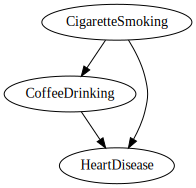

In [63]:
concreteconfounder=graphviz.Digraph()
concreteconfounder.edge('CigaretteSmoking','CoffeeDrinking')
concreteconfounder.edge('CigaretteSmoking','HeartDisease')
concreteconfounder.edge('CoffeeDrinking','HeartDisease')
concreteconfounder

#### Mediator

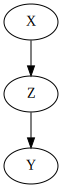

In [64]:
mediator=graphviz.Digraph()
mediator.edge('X','Z')
mediator.edge('Z','Y')
mediator

#### This example shows how we define:
- a DAG
- and the raw data
- and for sake of easy visualization show the DAG as a graphviz.Digraph()
#### Note:
- The parameters for the the Conditional Probability Distribution (CPD) are calculated automatically.
- In the example above, we did input the DAG and CPD

In [65]:
model = BayesianNetwork([('A', 'B'), ('B', 'C'),
                       ('A', 'D'), ('D', 'C')])
values = pandas.DataFrame(np.random.randint(low=0, high=2, size=(1000, 4)),
                      columns=['A', 'B', 'C', 'D'])
model.fit(values)
for cpdList in model.get_cpds():
        print(cpdList)
#cpdB = model.get_cpds('B')
#print(cpdB)

+------+-------+
| A(0) | 0.498 |
+------+-------+
| A(1) | 0.502 |
+------+-------+
+------+--------------------+---------------------+
| A    | A(0)               | A(1)                |
+------+--------------------+---------------------+
| B(0) | 0.5060240963855421 | 0.49203187250996017 |
+------+--------------------+---------------------+
| B(1) | 0.4939759036144578 | 0.5079681274900398  |
+------+--------------------+---------------------+
+------+--------------------+--------------------+---------------------+---------------------+
| B    | B(0)               | B(0)               | B(1)                | B(1)                |
+------+--------------------+--------------------+---------------------+---------------------+
| D    | D(0)               | D(1)               | D(0)                | D(1)                |
+------+--------------------+--------------------+---------------------+---------------------+
| C(0) | 0.5214285714285715 | 0.5068493150684932 | 0.44609665427509293 | 0.5

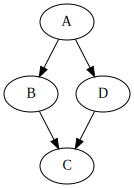

In [66]:
# Next Model - The Bayesian Net structure
random=graphviz.Digraph()
random.edge('A','B')
random.edge('B','C')
random.edge('A','D')
random.edge('D','C')
random

## Causal Model

All we need to get started is:
- A DAG - which we have created above
- Raw data that has each of the nodes as a column - we do not have this, because we just created the CPD. However, we can use CPD (Bayesian Net) and generate data for us sampling from that probability distribution. Let us do it.

In [67]:
df =student_model.simulate(n_samples=1000)
df

  0%|          | 0/5 [00:00<?, ?it/s]

,Grade,Difficulty,Intelligence,Letter,SATScore
0,0,1,1,1,1
1,2,1,0,0,0
2,1,1,0,0,0
3,0,1,1,0,1
4,2,0,0,0,0
...,...,...,...,...,...
995,2,0,0,0,0
996,2,0,0,0,1
997,2,0,0,0,0
998,0,0,0,1,0


### Use standard doWhy API

- Question we want to answer is:
  - ATE aka Average Treatment Effect: What happens to the outcome (letter) if we increase the intelligence by 1 unit (0 to 1)


We are all set to create the CausalModel now.

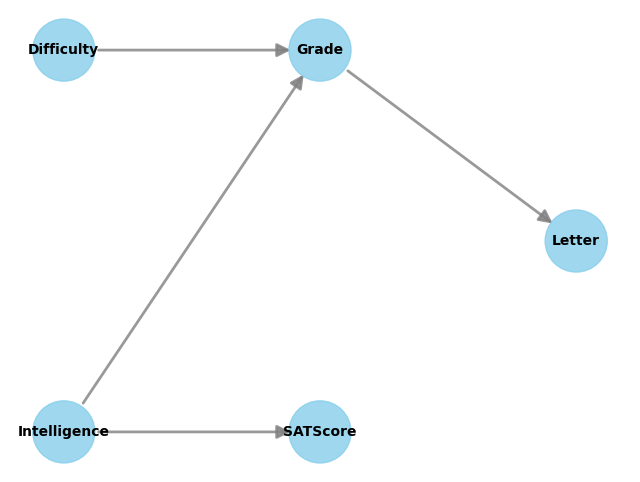

In [68]:
model= CausalModel(
        data=df,
        graph=bbn,
        treatment="Intelligence",
        outcome="Letter")
model.view_model()

In [69]:
print(model.get_common_causes())
print(model.get_effect_modifiers())
print(model.get_instruments())
model.summary()

[]
['Difficulty']
[]


"Model to find the causal effect of treatment ['Intelligence'] on outcome ['Letter']"

Model to find the causal effect of treatment ['Intelligence'] on outcome ['Letter']


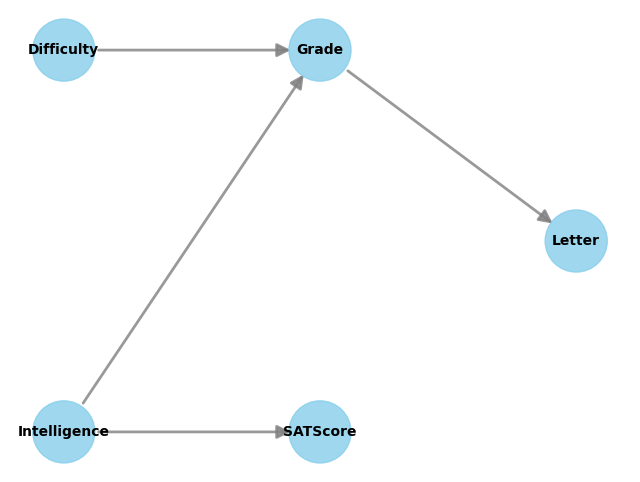

In [70]:
model.interpret()
#model.view_model()

In [71]:
identified_estimand=model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                  
───────────────(E[Letter])
d[Intelligence]           
Estimand assumption 1, Unconfoundedness: If U→{Intelligence} and U→Letter then P(Letter|Intelligence,,U) = P(Letter|Intelligence,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡        d                         ∂                          ⎤
E⎢──────────────────(Letter)⋅───────────────([Grade  SATScore])⎥
 ⎣d[Grade  SATScore]         ∂[Intelligence]                   ⎦
Estimand assumption 1, Full-mediation: Grade,SATScore intercepts (blocks) all directed paths from Intelligence to L,e,t,t,e,r.
Estimand assumption 2, First-stage-unconfoundedness: If U→{Intelligence} and U→{Grade,SATScore} then P(Grade,SATScore|Intelligence,U) = P(Grade,SATScore|Intelligence)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{Gra

In [72]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print(causal_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                  
───────────────(E[Letter])
d[Intelligence]           
Estimand assumption 1, Unconfoundedness: If U→{Intelligence} and U→Letter then P(Letter|Intelligence,,U) = P(Letter|Intelligence,)

## Realized estimand
b: Letter~Intelligence+Intelligence*Difficulty
Target units: 

## Estimate
Mean value: 0.36369387438320505
### Conditional Estimates
__categorical__Difficulty
(-0.001, 1.0]    0.363694
dtype: float64


In [73]:
causal_estimate.interpret()

Increasing the treatment variable(s) [Intelligence] from 0 to 1 causes an increase of 0.36369387438320505 in the expected value of the outcome [['Letter']], over the data distribution/population represented by the dataset.


## Use GCM doWhy API
- Question we want to answer is:
    - ATE aka Average Treatment Effect: What happens to the outcome (letter) if we increase the intelligence by 1 unit (0 to 1)
    - We could answer a few more questions apart from the above. But we will leave it for a more detailed notebook.

### IGNORE Below this - not complete

In [74]:
# Create the structural causal model object
scm_model = gcm.StructuralCausalModel(bbn)

In [75]:
# Automatically assign generative models to each node based on the given data
analysis = gcm.auto.assign_causal_mechanisms(scm_model, df, override_models=True, quality=gcm.auto.AssignmentQuality.GOOD)
print(analysis)

When using this auto assignment function, the given data is used to automatically assign a causal mechanism to each node. Note that causal mechanisms can also be customized and assigned manually.
The following types of causal mechanisms are considered for the automatic selection:

If root node:
An empirical distribution, i.e., the distribution is represented by randomly sampling from the provided data. This provides a flexible and non-parametric way to model the marginal distribution and is valid for all types of data modalities.

If non-root node and the data is continuous:
Additive Noise Models (ANM) of the form X_i = f(PA_i) + N_i, where PA_i are the parents of X_i and the unobserved noise N_i is assumed to be independent of PA_i.To select the best model for f, different regression models are evaluated and the model with the smallest mean squared error is selected.Note that minimizing the mean squared error here is equivalent to selecting the best choice of an ANM.

If non-root node

In [76]:
# Fitting the SCM to the data:
gcm.fit(scm_model,df)

Fitting causal mechanism of node Letter: 100%|██████████| 5/5 [00:00<00:00, 55.09it/s]


Test permutations of given graph: 100%|██████████| 50/50 [00:12<00:00,  3.93it/s]


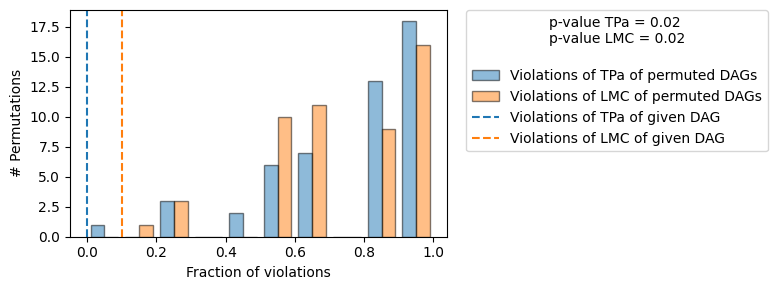

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [77]:
evaluation_result=gcm.model_evaluation.evaluate_causal_model(scm_model,df)
print(evaluation_result)

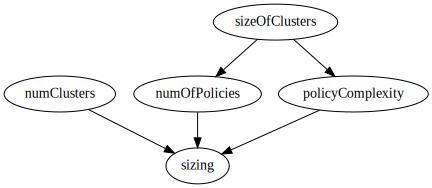

In [78]:
acm=graphviz.Digraph()
acm.edge('numClusters','sizing')
acm.edge('sizeOfClusters','numOfPolicies')
acm.edge('numOfPolicies','sizing')
acm.edge('policyComplexity','sizing')
acm.edge('sizeOfClusters','policyComplexity')
acm